In [111]:
import os
import tridy
from tridy import GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID,  AdmUnitFeature, OLUFeature, Grid, Imagee, ds_from_metadata, xml_lpis_cz_reader, lpis_cz__posledni_aktualizace, get_listvalues_from_generator, apply_function, select_nodes_from_graph, unzip_file, find_neighbors_till, connection_parameters_to_pg, transform_name_to_postgresql_format, world_to_pixel 
from importlib import reload
import requests
import datetime
import re
from io import BytesIO

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

from osgeo import ogr, osr, gdal
import networkx as nx
import numpy as np
import json
import binascii
import copy
import time

from lxml import etree

import random
from ipyleaflet import Map, GeoJSON

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from pygeoprocessing import routing

import tempfile
from tempfile import TemporaryDirectory

In [112]:
del(GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID, AdmUnitFeature, OLUFeature, Grid, Imagee, ds_from_metadata,xml_lpis_cz_reader,get_listvalues_from_generator,apply_function,select_nodes_from_graph,world_to_pixel)
reload(tridy)
from tridy import GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID, AdmUnitFeature, OLUFeature, Grid, Imagee, ds_from_metadata, xml_lpis_cz_reader, get_listvalues_from_generator, apply_function, select_nodes_from_graph,world_to_pixel

In [117]:
def get_twi(im_object):
    with TemporaryDirectory() as tempdir:
        im_object.export_as_tif('%s/dem.tif' %tempdir)
        routing.fill_pits(('%s/dem.tif' %tempdir,1),'%s/cdem.tif' %tempdir)
        routing.flow_dir_mfd(('%s/cdem.tif' %tempdir,1),'%s/dir.tif' %tempdir)
        routing.flow_accumulation_mfd(('%s/dir.tif' %tempdir,1),'%s/twi.tif' %tempdir)
        ds = gdal.Open('%s/twi.tif' %tempdir)
        metadata_dict=im_object.get_metadata()
        twi=Imagee(np.array(ds.GetRasterBand(1).ReadAsArray()),metadata_dict)
        return twi

In [3]:
def random_color(feature):
    return {
        'color': 'black',
        'fillColor': random.choice(['red', 'yellow', 'green', 'orange']),
    }

In [4]:
def compilable_tree_dictionary(object): 
    g_dict=\
    {'admunit':{'object':object},\
    'admunit__tree':{'object':'admunit','function':'return_graph_representation'},\
    'admunit__tree__reverse':{'object':'admunit__tree','function':'reverse'},\
    'admunit__tree__level3':{'function':select_nodes_from_graph,'parameters':['admunit__tree','level',3]},\
    'admunit__tree__level4':{'function':select_nodes_from_graph,'parameters':['admunit__tree','level',4]}}
    return g_dict

In [5]:
def find_neighbors_level(graph,start_node,level):
    if graph.nodes()[start_node]['level']==level:
        yield start_node
    else:
        for n in graph.neighbors(start_node):
            yield from find_neighbors_level(graph,n,level) 

In [6]:
def get_ruian_au_feature_geometry_from_wfs(gml_id):
    url='https://services.cuzk.cz/wfs/inspire-au-wfs.asp?service=WFS&request=GetFeature&typeName=au:AdministrativeUnit&maxFeatures=1&featureID=%s&version=2.0.0' %gml_id
    r=requests.get(url,stream=False)
    if r.status_code==200:
        tree=etree.parse(BytesIO(r.content))
        root=tree.getroot()
        geom=root.find('.//{http://www.opengis.net/gml/3.2}MultiSurface')
        geom_ogr=ogr.CreateGeometryFromGML(etree.tostring(geom).decode())
        return geom_ogr.ExportToWkt()
    else:
        return 'WFS no works'

In [7]:
#for the case when data has to be downloaded externally initialization of requests session variable with setting of number of retries
s = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
s.mount('http://', HTTPAdapter(max_retries=retries))

In [8]:
replacement_dictionary = {"[posledni_den_mesice]":(datetime.datetime.today().replace(day=1)-datetime.timedelta(days=1)).strftime('%Y%m%d'),"[lpis_cz__posledni_aktualizace]":lpis_cz__posledni_aktualizace().strftime('%Y%m%d'), "[vcera]":(datetime.datetime.today().replace(day=1)-datetime.timedelta(days=1)).strftime('%Y%m%d')} 
json_feature_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"}]
json_feature_with_bigid_structure=[{"name":"id","type":"bigint primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"}]
json_admin_unit_structure=[{"name":"id","type":"integer primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"level","type":"integer"},{"name":"parent_id","type":"text"}]
json_admin_unit_structure_at=[{"name":"id","type":"text primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"level","type":"integer"},{"name":"parent_id","type":"text"}]
json_feature_with_raster_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"raster_maps","type":"raster"}]

In [9]:
admunit_cz__metadata=MetaData('Administrative units in Czech Republic',
                              {"url":"https://vdp.cuzk.cz/vymenny_format/soucasna/[posledni_den_mesice]_ST_UKSG.xml.zip",
                               "format":"GML", "compression":"zip"},'data')

In [10]:
admunit_cz__ds=ds_from_metadata(admunit_cz__metadata)
admunit_cz=GeoConcept('Administrative units in Czech Republic','Administrative units in Czech Republic. All levels.',
                      'AdmUnitFeature',json_admin_unit_structure, data_source=admunit_cz__ds, subgeoconcepts=[] )

In [11]:
url_adresa=admunit_cz.get_data_source().get_attributes()['url']
for i in re.findall('\[.*?\]',url_adresa):
    if i in list(replacement_dictionary.keys()):
        url_adresa=url_adresa.replace(i,replacement_dictionary[i])
        
admunit_cz.get_data_source().set_attribute({'url':url_adresa})
del(url_adresa)

In [12]:
#admunit_cz.get_data_source().download_data('archive.zip',s,'all',os.getcwd())
admunit_cz.get_data_source().set_data_file('20201031_ST_UKSG.xml')

In [13]:
concept_list=['Staty','Vusc','Okresy','Obce','KatastralniUzemi']
concept_additional_attributes={'Staty':{'level_value':0,'parent_value':'null','id_attribute':'Kod'},
                               'Vusc':{'level_value':1,'parent_value':'1','id_attribute':'Kod'},
                               'Okresy':{'level_value':2,'parent_attribute':'VuscKod','id_attribute':'Kod'},
                               'Obce':{'level_value':3,'parent_attribute':'OkresKod','id_attribute':'Kod'},
                               'KatastralniUzemi':{'level_value':4,'parent_attribute':'ObecKod','id_attribute':'Kod'}}

In [14]:
for l in list(set(concept_list).intersection(set(admunit_cz.get_data_source().list_layers()))):
    admunit_cz.append_subgeoconcept(SubGeoConcept(l,l,'AdmUnitFeature',admunit_cz.get_attributes(),data_source=DataSource(admunit_cz.get_data_source().get_type(),admunit_cz.get_data_source().get_name(),({**admunit_cz.get_data_source().get_attributes(),**{'layer':l}}),None,admunit_cz.get_data_source().get_data_file()),supergeoconcept=admunit_cz,table_inheritance=False,type='semantic',subgeoconcepts=[]))

In [15]:
#administrative territorial units
dbs_admin_connection={'dbname':'olu_administrative_units','user':'euxdat_admin','host':'euxdat-db-svc','port':'5432','password':'Euxdat12345'}
dbs_admin=DBStorage(dbs_admin_connection)
dbs_admin.connect()
dbs_admin.disconnect()
dbs_admin.connect()

#lpis in czech republic
dbs_lpis_cz_connection={'dbname':'lpis_cz','user':'euxdat_admin','host':'euxdat-db-svc','port':'5432','password':'Euxdat12345'}
dbs_lpis_cz=DBStorage(dbs_lpis_cz_connection)
dbs_lpis_cz.connect()
dbs_lpis_cz.disconnect()
dbs_lpis_cz.connect()

In [16]:
admunit_cz.create_table(dbs_admin, name='default',scheme='cz',conflict='append')

In [17]:
for sub in admunit_cz.get_subgeoconcepts():
    sub.set_table(View(sub.get_name(),sub.get_attributes(), sub.get_supergeoconcept().get_table(),"level=%s" % (concept_additional_attributes[sub.get_name()]['level_value']), dbs=dbs_admin, scheme='public', type='usual'))
    dbs_admin.execute(sub.get_table().create_script())

In [18]:
lpis_cz__metadata=MetaData('LPIS in Czech Republic',
                              [{"url":"http://eagri.cz/public/app/eagriapp/lpisdata/[lpis_cz__posledni_aktualizace]-{admunit__tree__level4}-DPB-SHP.zip",
                               "format":"SHP", "compression":"zip"},{"url":"http://eagri.cz/public/app/eagriapp/lpisdata/[lpis_cz__posledni_aktualizace]-{admunit__tree__level4}-DPB-XML-A.zip",
                               "format":"XML", "compression":"zip"}],'data')
lpis_cz__ds_xml=ds_from_metadata(lpis_cz__metadata,format='XML')
lpis_cz=GeoConcept('LPIS in Czech Republic','LPIS in Czech Republic. All levels.',
                      'Feature',json_feature_structure, data_source=lpis_cz__ds_xml, subgeoconcepts=[], adm_graph_node='1')

In [19]:
lpis_cz.create_table(dbs_lpis_cz,name='default',scheme='public',conflict='append')

In [20]:
url_adresa=lpis_cz.get_data_source().get_attributes()['url']
for i in re.findall('\[.*?\]',url_adresa):
    if i in list(replacement_dictionary.keys()):
        url_adresa=url_adresa.replace(i,replacement_dictionary[i])
lpis_cz.get_data_source().set_attribute({'url':url_adresa})
del(url_adresa)

In [21]:
for i in re.findall('\{.*?\}',lpis_cz.get_data_source().get_attributes()['url']): 
    if i[1:-1] in list(compilable_tree_dictionary(admunit_cz).keys()):
        for j in apply_function(compilable_tree_dictionary(admunit_cz),i[1:-1]):
            lpis_cz.append_subgeoconcept(SubGeoConcept(str(j),'LPIS in Czech administrative territorial unit %s ' % str(j),'Feature',lpis_cz.get_attributes(),data_source=DataSource(lpis_cz.get_data_source().get_type(),lpis_cz.get_data_source().get_name(),(dict(lpis_cz.get_data_source().get_attributes(),**{'url':lpis_cz.get_data_source().get_attributes()['url'].replace(i,str(j))})),None,None),supergeoconcept=lpis_cz,table_inheritance=True,subgeoconcepts=[],type='spatial:admin',adm_graph_node=str(j)))

In [22]:
for sub in lpis_cz.get_subgeoconcepts():
    #sub.get_data_source().download_data('archive.zip',s,'all',os.getcwd())
    #sub.create_table(dbs_lpis_cz,name=sub.get_name(),scheme='data',conflict='replace')
    #features=sub.get_data_source().read_features('feature',number=10,reader=xml_lpis_cz_reader)
    #dbs_lpis_cz.insert_many('insert into %s (geom,data) ' % (transform_name_to_postgresql_format(sub.get_table().get_scheme())+'.'+transform_name_to_postgresql_format(sub.get_table().get_name())) ,features,20)
    #os.remove(sub.get_data_source().get_data_file())
    sub.create_table(dbs_lpis_cz,name=sub.get_name(),scheme='data',conflict='append',adm_graph_node=sub.get_adm_graph_node())

In [27]:
dem30_fn='dem30/eu_dem_czat3035.tif'
dem30=gdal.Open(dem30_fn)

In [23]:
sub=lpis_cz.get_subgeoconcept_by_name('651524')

In [29]:
wgs84_sr,sjtsk5514_sr,etrs3035_sr=[osr.SpatialReference() for i in range(3)]
wgs84_sr.ImportFromProj4('+proj=longlat +datum=WGS84 +no_defs')

sjtsk5514_sr.ImportFromProj4('+proj=krovak +lat_0=49.5 +lon_0=24.83333333333333 +alpha=30.28813975277778 +k=0.9999 +x_0=0 +y_0=0 +ellps=bessel +units=m +towgs84=570.8,85.7,462.8,4.998,1.587,5.261,3.56 +no_defs')

etrs3035_sr.ImportFromProj4('+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')

sjtsk5514_to_wgs84=osr.CoordinateTransformation(sjtsk5514_sr,wgs84_sr)
sjtsk5514_to_etrs3035=osr.CoordinateTransformation(sjtsk5514_sr,etrs3035_sr)

In [30]:
metadata_dict={}
metadata_dict['affine_transformation']=dem30.GetGeoTransform()
metadata_dict['nodata']=dem30.GetRasterBand(1).GetNoDataValue()
metadata_dict['proj_wkt']=etrs3035_sr.ExportToWkt()

In [36]:
features=admunit_cz.read_features_from_table_by_sqlcondition(sqlcondition="id=538493", number=1)

In [37]:
f=next(features)[0]

In [40]:
f.transform_geometry(sjtsk5514_to_etrs3035)

In [42]:
grid=Grid((metadata_dict['affine_transformation'][0],metadata_dict['affine_transformation'][3]),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [48]:
feature_geometry3035=ogr.CreateGeometryFromWkt(f.get_geometry())

In [49]:
origin=tuple(grid.find_index((feature_geometry3035.GetEnvelope()[0],feature_geometry3035.GetEnvelope()[3])))

In [50]:
size=tuple(np.array(grid.find_index((feature_geometry3035.GetEnvelope()[1],feature_geometry3035.GetEnvelope()[2])))-np.array(grid.find_index((feature_geometry3035.GetEnvelope()[0],feature_geometry3035.GetEnvelope()[3]))))+np.array([1,1])

In [51]:
a=np.array(dem30.GetRasterBand(1).ReadAsArray(xoff=int(origin[0]),yoff=int(origin[1]),win_xsize=int(size[0]),win_ysize=int(size[1])))

In [52]:
grid_clip=Grid(np.array(grid.get_gridorigin())+np.array(tuple(grid.find_index((feature_geometry3035.GetEnvelope()[0],feature_geometry3035.GetEnvelope()[3]))))*np.array(grid.get_gridstepsize()),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [53]:
clip_metadata_dict={}
clip_metadata_dict['affine_transformation']=grid_clip.get_affinetransformation()
clip_metadata_dict['nodata']=float(np.min(a)) if np.min(a)<0 else np.nan
clip_metadata_dict['proj_wkt']=etrs3035_sr.ExportToWkt()

In [54]:
im=Imagee(a,clip_metadata_dict)

In [55]:
im.export_as_tif('Mnichovice.tif')

In [56]:
G=apply_function(compilable_tree_dictionary(admunit_cz),'admunit__tree')

In [70]:
list(find_neighbors_level(G.reverse(),str(f.get_data()['Kod']),4))

['697541', '697532', '697559']

In [71]:
features_lpis=lpis_cz.get_subgeoconcept_by_name('697541').read_features_from_table(1)

In [72]:
feature_lpis=next(features_lpis)[0]

In [73]:
feature_lpis.transform_geometry(sjtsk5514_to_etrs3035)

In [74]:
feature_lpis_geometry3035=ogr.CreateGeometryFromWkt(feature_lpis.get_geometry())

In [75]:
cropped_im=Imagee(*im.clip_by_shape(feature_lpis_geometry3035.ExportToWkt()))

In [76]:
cropped_im.export_as_tif('pole.tif')

In [78]:
feature_lpis_geometry3035.ExportToWkt()

'POLYGON ((4660479.59816091 2991180.78131692,4660480.74335825 2991179.55023157,4660486.72157905 2991173.89037725,4660469.58634304 2991153.65976522,4660485.66414388 2991117.5530257,4660504.46009662 2991050.38187858,4660562.22459566 2991061.89851968,4660562.22178342 2991064.63134151,4660563.26976364 2991067.15586663,4660565.19947393 2991069.09155643,4660567.7242879 2991070.13638368,4660570.45578589 2991070.14137664,4660572.97825032 2991069.09490022,4660574.91146204 2991067.16579547,4660575.95376889 2991064.64058729,4660577.30527057 2991057.84370036,4660568.01612241 2991055.71854887,4660570.8022717 2991040.36764032,4660572.14933382 2991040.35283955,4660580.19124992 2991040.6096629,4660590.77626909 2991041.64438206,4660617.60588491 2991047.81255868,4660651.43202441 2991047.28241442,4660682.29780559 2991044.00225256,4660708.9620425 2991041.50195597,4660736.55794567 2991037.02897865,4660747.13539994 2991031.31583415,4660757.35766932 2991032.81774971,4660775.8798752 2991033.27887963,4660796.0

In [84]:
grid_clip.get_gridorigin()

array([4657465.86623567, 2993048.78936134])

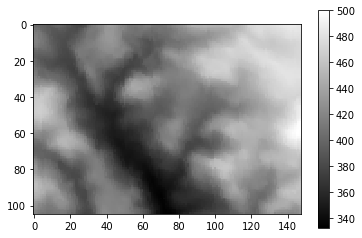

In [127]:
plt.imshow(im.get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

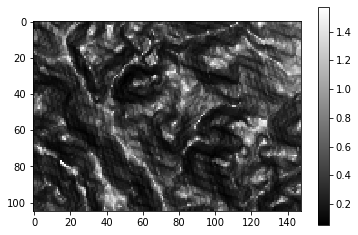

In [121]:
plt.imshow(Imagee(*im.calculate_slope()).get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

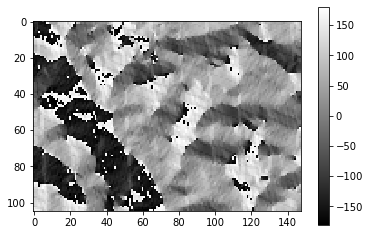

In [122]:
plt.imshow(Imagee(*im.calculate_azimuth()).get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [119]:
mnichovice_twi=get_twi(im)

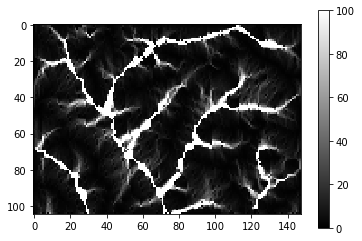

In [124]:
plt.imshow(mnichovice_twi.get_data(), origin="upper", cmap='gray', interpolation='nearest',vmin=0,vmax=100)
plt.colorbar()
plt.show()

In [120]:
mnichovice_twi.export_as_tif('Mnichovice_twii.tif')

In [125]:
cropped_im__twi=Imagee(*mnichovice_twi.clip_by_shape(feature_lpis_geometry3035.ExportToWkt()))

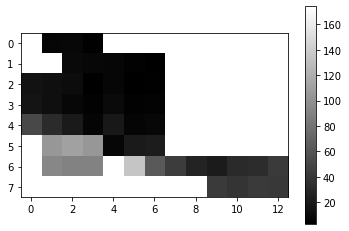

In [126]:
plt.imshow(cropped_im__twi.get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()